# Title:
Autoencoders and Variational Autoencoders for Image Reconstruction

# Objective:
- To evaluate and compare the performance of Autoencoders (AE) and Variational Autoencoders (VAE) in reconstructing images.
- To explore the impact of hyperparameters, particularly the number of epochs and learning rate, on the quality of image reconstruction.
- To investigate how these models perform on a smaller dataset and understand the trade-offs between accuracy, computational cost, and training time.
  
# Theory:
1. **Autoencoder (AE):**
   - An Autoencoder is a type of artificial neural network used to learn efficient representations of data, typically for the purpose of dimensionality reduction or feature learning. The network consists of two main parts:
     - **Encoder:** Maps the input data into a lower-dimensional latent space representation.
     - **Decoder:** Reconstructs the input data from the encoded representation.
   - AE models are trained by minimizing the difference between the input and the reconstructed output, typically using a reconstruction loss function like Mean Squared Error (MSE).
   - The key advantage of AE is that it learns to represent input data efficiently, which is useful in tasks like data compression, anomaly detection, and denoising.

2. **Variational Autoencoder (VAE):**
   - The Variational Autoencoder is a probabilistic extension of the standard Autoencoder that introduces a latent variable model. The VAE aims to approximate a distribution over the data rather than a deterministic mapping.
   - **Encoder:** In VAE, the encoder produces two outputs: the mean and the variance of the latent variables, from which the latent representation is sampled.
   - **Decoder:** Decodes the latent representation back into the original input space.
   - VAE models are trained to minimize the reconstruction loss (like AE) and the Kullback-Leibler (KL) divergence between the learned latent space distribution and a prior distribution (often Gaussian). This helps in generating new data samples from the learned distribution.
   - VAEs are widely used in generative tasks like image synthesis and data augmentation.

3. **Epochs and Learning Rate:**
   - **Epochs:** Refers to the number of complete passes through the training dataset. As the number of epochs increases, the model gets more opportunities to learn patterns in the data, but it can also lead to overfitting, especially with smaller datasets.
   - **Learning Rate:** The learning rate controls the step size taken by the optimizer during training. A higher learning rate can lead to faster convergence but may cause the model to overshoot optimal solutions, while a lower learning rate can result in slower convergence but more stable learning. Balancing the learning rate is crucial for effective training, especially in deep learning tasks like image reconstruction.

This experiment aims to understand how these key factors (epochs, learning rate) influence the reconstruction quality of AE and VAE models and determine how these models behave on smaller datasets. It also seeks to highlight the trade-offs between training time, computational cost, and performance in real-world applications.

# Code:

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
# defining the device to use 'cuda' (GPU) for computation
device = torch.device("cuda")

# printing the device to check if it's correctly set
print(device)

cuda


In [3]:
# defining the transformations to apply to images before using them
transform = transforms.Compose([
    # resizing the images to 64x64 pixels
    transforms.Resize((64, 64)),
    
    # converting the images to tensors so they can be used by the model
    transforms.ToTensor(),
    
    # normalizing the image pixel values to be between -1 and 1
    transforms.Normalize((0.5,), (0.5,))
])


In [4]:
# loading the image dataset from a folder, applying the defined transformations
dataset = datasets.ImageFolder(root='/kaggle/input/dog-breed-image-dataset/dataset', transform=transform)

# creating a data loader to load the dataset in batches of 32 images, and shuffling the data
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [5]:
# defining the Autoencoder class which is a type of neural network for encoding and decoding data
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        # calling the parent class constructor
        super().__init__()
        
        # defining the encoder part of the autoencoder
        self.encoder = nn.Sequential(
            # flattening the input image of size 64x64x3 into a 1D vector of size 64*64*3
            nn.Linear(64*64*3, 512),
            
            # applying ReLU activation function for non-linearity
            nn.ReLU(),
            
            # reducing the dimensions to the latent space (e.g., 128)
            nn.Linear(512, latent_dim)
        )
        
        # defining the decoder part of the autoencoder
        self.decoder = nn.Sequential(
            # expanding the latent space to 512 dimensions
            nn.Linear(latent_dim, 512),
            
            # applying ReLU activation function again
            nn.ReLU(),
            
            # expanding back to the original image size of 64*64*3
            nn.Linear(512, 64*64*3),
            
            # using Tanh to bring the pixel values back to the range [-1, 1]
            nn.Tanh()
        )

    # defining the forward pass of the autoencoder
    def forward(self, x):
        # flattening the input images to a 1D vector
        x = x.view(x.size(0), -1)
        
        # passing the data through the encoder
        encoded = self.encoder(x)
        
        # passing the encoded data through the decoder to reconstruct the image
        decoded = self.decoder(encoded)
        
        # reshaping the decoded output back to the original image shape (64x64x3)
        return decoded.view(x.size(0), 3, 64, 64)

In [6]:
# defining the Variational Autoencoder (VAE) class, which is a type of neural network for generative tasks
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        # calling the parent class constructor
        super().__init__()
        
        # defining the encoder part of the VAE
        self.encoder = nn.Sequential(
            # flattening the input image of size 64x64x3 into a 1D vector of size 64*64*3
            nn.Linear(64*64*3, 512),
            
            # applying ReLU activation function for non-linearity
            nn.ReLU()
        )
        
        # defining the fully connected layers for the mean (mu) and log variance (logvar)
        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)
        
        # defining the decoder part of the VAE
        self.decoder = nn.Sequential(
            # expanding the latent space to 512 dimensions
            nn.Linear(latent_dim, 512),
            
            # applying ReLU activation function again
            nn.ReLU(),
            
            # expanding back to the original image size of 64*64*3
            nn.Linear(512, 64*64*3),
            
            # using Tanh to bring the pixel values back to the range [-1, 1]
            nn.Tanh()
        )

    # defining the reparameterization trick for sampling from the latent space
    def reparameterize(self, mu, logvar):
        # calculating the standard deviation from the log variance
        std = torch.exp(0.5 * logvar)
        
        # generating random noise from a normal distribution
        eps = torch.randn_like(std)
        
        # returning the sample from the latent space
        return mu + eps * std

    # defining the forward pass of the VAE
    def forward(self, x):
        # flattening the input images to a 1D vector
        x = x.view(x.size(0), -1)
        
        # passing the data through the encoder
        x = self.encoder(x)
        
        # calculating the mean and log variance for the latent space
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        
        # sampling from the latent space using the reparameterization trick
        z = self.reparameterize(mu, logvar)
        
        # passing the sampled latent space through the decoder to reconstruct the image
        decoded = self.decoder(z)
        
        # reshaping the decoded output back to the original image shape (64x64x3)
        return decoded.view(x.size(0), 3, 64, 64), mu, logvar

In [7]:
# defining the function to train the Autoencoder model
def train_autoencoder(model, dataloader, epochs=10, lr=1e-3):
    # setting up the optimizer (Adam) for model parameters with the learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # using Mean Squared Error loss as the loss function
    criterion = nn.MSELoss()
    
    # moving the model to the defined device (GPU or CPU)
    model.to(device)

    # training the model for the given number of epochs
    for epoch in range(epochs):
        # iterating through the dataloader for each batch of images
        for images, _ in dataloader:
            # moving the images to the defined device
            images = images.to(device)
            
            # passing the images through the model to get outputs (reconstructed images)
            outputs = model(images)
            
            # calculating the loss (difference between original and reconstructed images)
            loss = criterion(outputs, images)
            
            # zeroing the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()
            
            # performing backpropagation to compute gradients
            loss.backward()
            
            # updating the model parameters based on the gradients
            optimizer.step()
        
        # printing the loss after each epoch to monitor training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    # returning the trained model
    return model

In [8]:
# defining the function to train the Variational Autoencoder (VAE) model
def train_vae(model, dataloader, epochs=10, lr=1e-3):
    # setting up the optimizer (Adam) for model parameters with the learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # moving the model to the defined device (GPU or CPU)
    model.to(device)

    # training the model for the given number of epochs
    for epoch in range(epochs):
        # initializing the total loss for this epoch
        total_loss = 0
        
        # iterating through the dataloader for each batch of images
        for images, _ in dataloader:
            # moving the images to the defined device
            images = images.to(device)
            
            # passing the images through the model to get reconstructed images, mean (mu), and log variance (logvar)
            reconstructed, mu, logvar = model(images)
            
            # calculating the reconstruction loss (mean squared error between original and reconstructed images)
            recon_loss = nn.functional.mse_loss(reconstructed, images)
            
            # calculating the KL divergence loss (how much the learned distribution deviates from a standard normal distribution)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            
            # the total loss is the sum of reconstruction loss and KL divergence loss
            loss = recon_loss + kl_loss
            
            # zeroing the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()
            
            # performing backpropagation to compute gradients
            loss.backward()
            
            # updating the model parameters based on the gradients
            optimizer.step()
            
            # accumulating the total loss for this epoch
            total_loss += loss.item()
        
        # printing the average loss after each epoch to monitor training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}")
    
    # returning the trained model
    return model

In [ ]:
# defining the function to train the Variational Autoencoder (VAE) model with back-propagation gradient printing
def train_vae(model, dataloader, epochs=10, lr=1e-3):
    # setting up the optimizer (Adam) for model parameters with the learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # moving the model to the defined device (GPU or CPU)
    model.to(device)

    # training the model for the given number of epochs
    for epoch in range(epochs):
        # initializing the total loss for this epoch
        total_loss = 0
        
        # iterating through the dataloader for each batch of images
        for batch_idx, (images, _) in enumerate(dataloader):
            # moving the images to the defined device
            images = images.to(device)
            
            # passing the images through the model to get reconstructed images, mean (mu), and log variance (logvar)
            reconstructed, mu, logvar = model(images)
            
            # calculating the reconstruction loss (mean squared error between original and reconstructed images)
            recon_loss = nn.functional.mse_loss(reconstructed, images)
            
            # calculating the KL divergence loss (how much the learned distribution deviates from a standard normal distribution)
            kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            
            # the total loss is the sum of reconstruction loss and KL divergence loss
            loss = recon_loss + kl_loss
            
            # zeroing the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()
            
            # performing backpropagation to compute gradients
            loss.backward()
            
            # printing the gradients for each layer in the model
            print(f"Batch {batch_idx+1} - Gradients:")
            for name, param in model.named_parameters():
                # checking if the parameter has gradients
                if param.grad is not None:
                    # printing the name of the layer and the norm of the gradient
                    print(f"Layer: {name}, Gradient Norm: {param.grad.norm().item():.6f}")
            
            # updating the model parameters based on the gradients
            optimizer.step()
            
            # accumulating the total loss for this epoch
            total_loss += loss.item()
        
        # printing the average loss after each epoch to monitor training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(dataloader):.4f}\n")
    
    # returning the trained model
    return model

In [9]:
# defining the function to visualize the original and reconstructed images
def visualize_reconstruction(model, dataloader, is_vae=False):
    # setting the model to evaluation mode (disables dropout and batch norm)
    model.eval()
    
    # getting a batch of images from the dataloader
    images, _ = next(iter(dataloader))
    images = images.to(device)  # moving images to the defined device (GPU or CPU)
    
    # performing inference without updating the model (no gradients)
    with torch.no_grad():
        if is_vae:
            # if VAE is used, get the reconstructed images from the model (VAE)
            reconstructed, _, _ = model(images)
        else:
            # for other models, get the reconstructed images
            reconstructed = model(images)

    # creating a plot with 2 rows and 8 columns to show original and reconstructed images
    fig, axes = plt.subplots(2, 8, figsize=(10, 4))
    
    # looping through the first 8 images
    for i in range(8):
        # displaying the original image (after converting from tensor to numpy array)
        axes[0, i].imshow(images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)  
        axes[0, i].axis('off')  # hiding axis
        
        # displaying the reconstructed image (after converting from tensor to numpy array)
        axes[1, i].imshow(reconstructed[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[1, i].axis('off')  # hiding axis
    
    # showing the plot with the images
    plt.show()

In [10]:
# Initialize and train models
ae_model = Autoencoder(latent_dim=128)
vae_model = VariationalAutoencoder(latent_dim=128)

In [11]:
ae_model = train_autoencoder(ae_model, dataloader, epochs=4)
vae_model = train_vae(vae_model, dataloader, epochs=3)

Epoch [1/3], Loss: 0.1271
Epoch [2/3], Loss: 0.0998
Epoch [3/3], Loss: 0.0778
Epoch [1/3], Loss: 0.3830
Epoch [2/3], Loss: 0.2717
Epoch [3/3], Loss: 0.2497


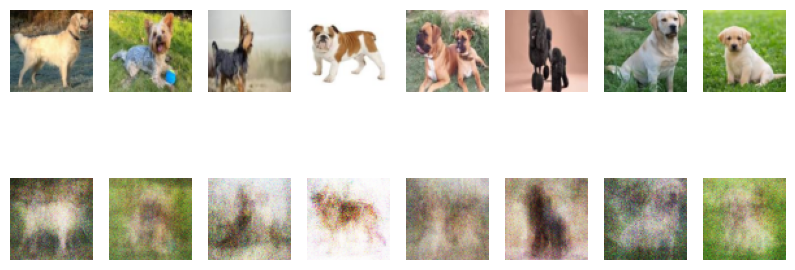

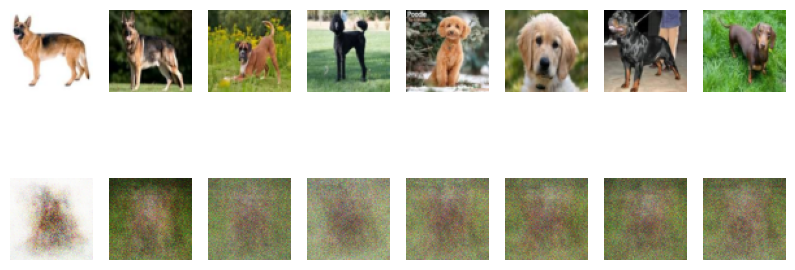

In [12]:
# Visualize results
visualize_reconstruction(ae_model, dataloader)
visualize_reconstruction(vae_model, dataloader, is_vae=True)

We can see that the outpput is very poor in both the cases. but AE is better as compared to the VAE. let's try with changing the number of epochs and make AE perform better

Epoch [1/8], Loss: 0.1457
Epoch [2/8], Loss: 0.0970
Epoch [3/8], Loss: 0.0801
Epoch [4/8], Loss: 0.0573
Epoch [5/8], Loss: 0.0429
Epoch [6/8], Loss: 0.0386
Epoch [7/8], Loss: 0.0267
Epoch [8/8], Loss: 0.0215


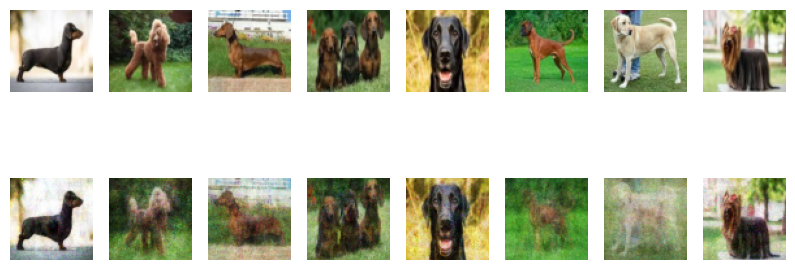

In [13]:
ae_model = Autoencoder(latent_dim=128)
ae_model = train_autoencoder(ae_model, dataloader, epochs=8)
visualize_reconstruction(ae_model, dataloader)

we can see that the performance has improvised, but not at its best. let's try with more number of epochs

Epoch [1/10], Loss: 0.1628
Epoch [2/10], Loss: 0.1120
Epoch [3/10], Loss: 0.0730
Epoch [4/10], Loss: 0.0530
Epoch [5/10], Loss: 0.0427
Epoch [6/10], Loss: 0.0365
Epoch [7/10], Loss: 0.0247
Epoch [8/10], Loss: 0.0161
Epoch [9/10], Loss: 0.0160
Epoch [10/10], Loss: 0.0201


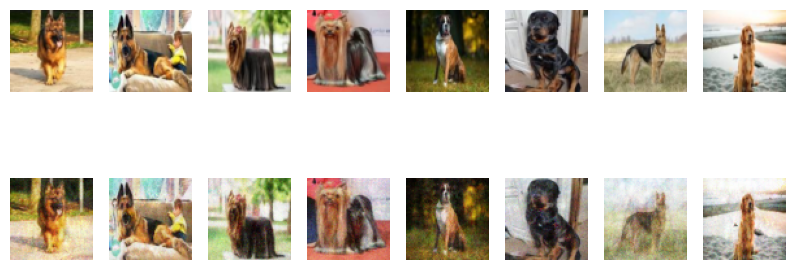

In [14]:
ae_model = Autoencoder(latent_dim=128)
ae_model = train_autoencoder(ae_model, dataloader, epochs=10)
visualize_reconstruction(ae_model, dataloader)

Epoch [1/15], Loss: 0.1491
Epoch [2/15], Loss: 0.0931
Epoch [3/15], Loss: 0.0943
Epoch [4/15], Loss: 0.0617
Epoch [5/15], Loss: 0.0497
Epoch [6/15], Loss: 0.0336
Epoch [7/15], Loss: 0.0322
Epoch [8/15], Loss: 0.0206
Epoch [9/15], Loss: 0.0166
Epoch [10/15], Loss: 0.0177
Epoch [11/15], Loss: 0.0173
Epoch [12/15], Loss: 0.0109
Epoch [13/15], Loss: 0.0090
Epoch [14/15], Loss: 0.0158
Epoch [15/15], Loss: 0.0070


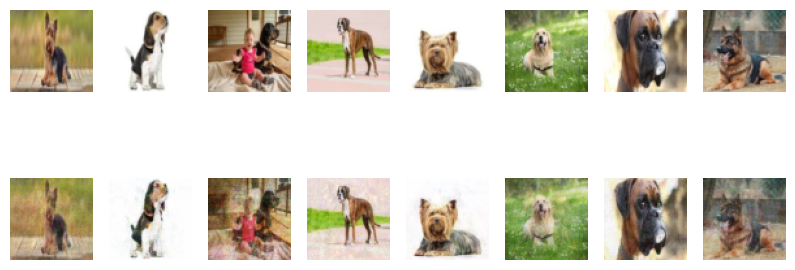

In [15]:
ae_model = Autoencoder(latent_dim=128)
ae_model = train_autoencoder(ae_model, dataloader, epochs=15)
visualize_reconstruction(ae_model, dataloader)

Epoch [1/30], Loss: 0.1597
Epoch [2/30], Loss: 0.0934
Epoch [3/30], Loss: 0.0882
Epoch [4/30], Loss: 0.0608
Epoch [5/30], Loss: 0.0404
Epoch [6/30], Loss: 0.0386
Epoch [7/30], Loss: 0.0269
Epoch [8/30], Loss: 0.0249
Epoch [9/30], Loss: 0.0193
Epoch [10/30], Loss: 0.0156
Epoch [11/30], Loss: 0.0109
Epoch [12/30], Loss: 0.0087
Epoch [13/30], Loss: 0.0103
Epoch [14/30], Loss: 0.0107
Epoch [15/30], Loss: 0.0089
Epoch [16/30], Loss: 0.0058
Epoch [17/30], Loss: 0.0138
Epoch [18/30], Loss: 0.0093
Epoch [19/30], Loss: 0.0066
Epoch [20/30], Loss: 0.0107
Epoch [21/30], Loss: 0.0073
Epoch [22/30], Loss: 0.0066
Epoch [23/30], Loss: 0.0034
Epoch [24/30], Loss: 0.0048
Epoch [25/30], Loss: 0.0082
Epoch [26/30], Loss: 0.0042
Epoch [27/30], Loss: 0.0043
Epoch [28/30], Loss: 0.0046
Epoch [29/30], Loss: 0.0043
Epoch [30/30], Loss: 0.0035


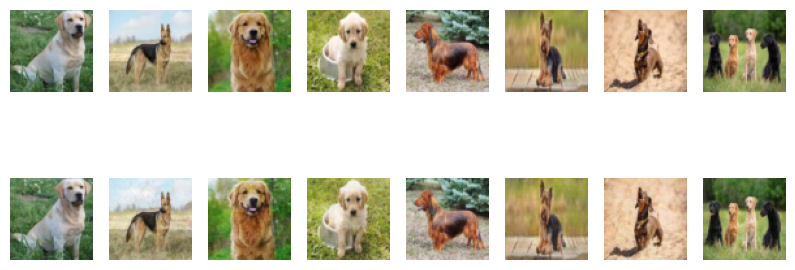

In [16]:
ae_model = Autoencoder(latent_dim=128)
ae_model = train_autoencoder(ae_model, dataloader, epochs=30)
visualize_reconstruction(ae_model, dataloader)

we can see as the number of the epochs increases, the re-constructed image is very close to the original image. but this dataset has got comparitively less number of images. but in reality, the actual datasets would have more images and would be more complex. in such cases, just increasing the number of epochs would not be useful as we need to attain to a golden mean between accuracy and computational expenses.

Epoch [1/3], Loss: 0.3106
Epoch [2/3], Loss: 0.2449
Epoch [3/3], Loss: 0.2078


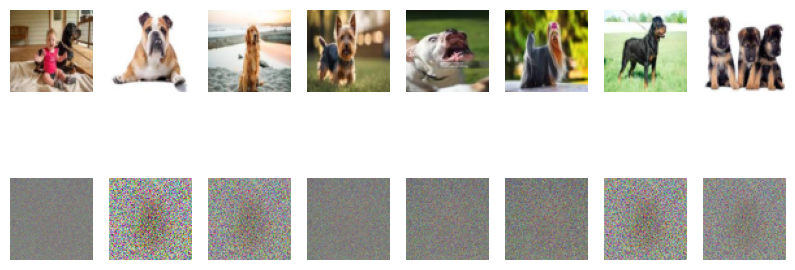

In [17]:
# defining the function to train the Autoencoder model
def train_autoencoder(model, dataloader, epochs=10, lr=1e-5):
    # setting up the optimizer (Adam) for model parameters with the learning rate
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # using Mean Squared Error loss as the loss function
    criterion = nn.MSELoss()
    
    # moving the model to the defined device (GPU or CPU)
    model.to(device)

    # training the model for the given number of epochs
    for epoch in range(epochs):
        # iterating through the dataloader for each batch of images
        for images, _ in dataloader:
            # moving the images to the defined device
            images = images.to(device)
            
            # passing the images through the model to get outputs (reconstructed images)
            outputs = model(images)
            
            # calculating the loss (difference between original and reconstructed images)
            loss = criterion(outputs, images)
            
            # zeroing the gradients to prevent accumulation from previous iterations
            optimizer.zero_grad()
            
            # performing backpropagation to compute gradients
            loss.backward()
            
            # updating the model parameters based on the gradients
            optimizer.step()
        
        # printing the loss after each epoch to monitor training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    # returning the trained model
    return model


we can see that as the learning rate is reduced that is the step size has been reduced, the quality of image reconstructed gets very poor

Epoch [1/3], Loss: 0.2871
Epoch [2/3], Loss: 0.3374
Epoch [3/3], Loss: 0.3341


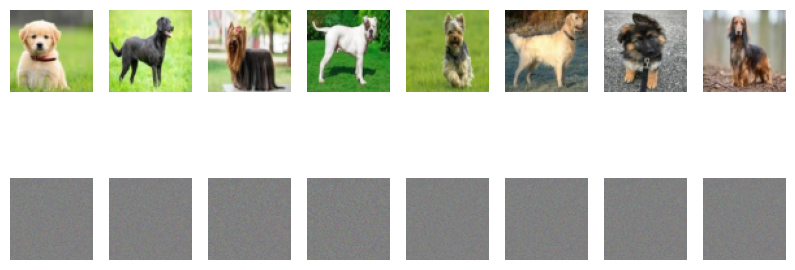

In [18]:
# defining the function to train the Autoencoder model
def train_autoencoder(model, dataloader, epochs=10, lr=1e-7):
    # initializing the Adam optimizer with a learning rate of 1e-7
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # using Mean Squared Error (MSE) loss for reconstruction
    criterion = nn.MSELoss()
    
    # moving the model to the device (GPU or CPU)
    model.to(device)

    # loop through the number of epochs
    for epoch in range(epochs):
        # loop through batches of images in the dataloader
        for images, _ in dataloader:
            images = images.to(device)  # moving the images to the device
            
            # getting the model output for the input images
            outputs = model(images)
            
            # calculating the loss (reconstruction error)
            loss = criterion(outputs, images)
            
            # clearing previous gradients
            optimizer.zero_grad()
            
            # performing backpropagation
            loss.backward()
            
            # updating model weights
            optimizer.step()
        
        # printing the loss for each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model  # returning the trained model

# initializing the Autoencoder model with a latent dimension of 128
ae_model = Autoencoder(latent_dim=128)

# training the Autoencoder model for 3 epochs using the provided dataloader
ae_model = train_autoencoder(ae_model, dataloader, epochs=3)

# visualizing the reconstruction of images from the trained Autoencoder model
visualize_reconstruction(ae_model, dataloader)

we can see that as the learning rate is decreased even further that is the step size has been reduced, the quality of image reconstructed gets very poor

Epoch [1/3], Loss: 1.3251
Epoch [2/3], Loss: 0.8697
Epoch [3/3], Loss: 1.1921


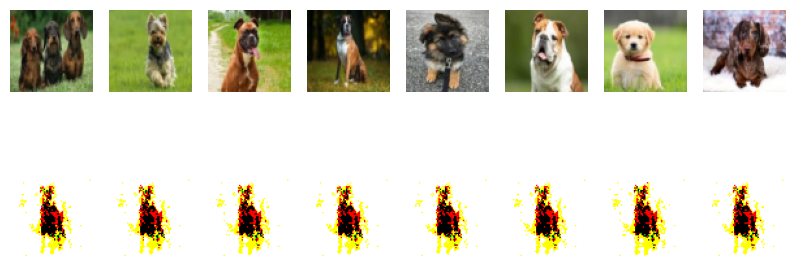

In [19]:
# defining the function to train the Autoencoder model
def train_autoencoder(model, dataloader, epochs=10, lr=1e-1):
    # initializing the Adam optimizer with a learning rate of 0.1 (1e-1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # using Mean Squared Error (MSE) loss for reconstruction
    criterion = nn.MSELoss()
    
    # moving the model to the device (GPU or CPU)
    model.to(device)

    # loop through the number of epochs
    for epoch in range(epochs):
        # loop through batches of images in the dataloader
        for images, _ in dataloader:
            images = images.to(device)  # moving the images to the device
            
            # getting the model output for the input images
            outputs = model(images)
            
            # calculating the loss (reconstruction error)
            loss = criterion(outputs, images)
            
            # clearing previous gradients
            optimizer.zero_grad()
            
            # performing backpropagation
            loss.backward()
            
            # updating model weights
            optimizer.step()
        
        # printing the loss for each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model  # returning the trained model

# initializing the Autoencoder model with a latent dimension of 128
ae_model = Autoencoder(latent_dim=128)

# training the Autoencoder model for 3 epochs using the provided dataloader
ae_model = train_autoencoder(ae_model, dataloader, epochs=3)

# visualizing the reconstruction of images from the trained Autoencoder model
visualize_reconstruction(ae_model, dataloader)

we can see that if the learning rate is increased i.e if the step size is increased, the overall outline is captured but it is still very poor and the quality of the image reconstructed still remains extremely poor

Epoch [1/5], Loss: 0.3153
Epoch [2/5], Loss: 0.2925
Epoch [3/5], Loss: 0.3356
Epoch [4/5], Loss: 0.3122
Epoch [5/5], Loss: 0.1983


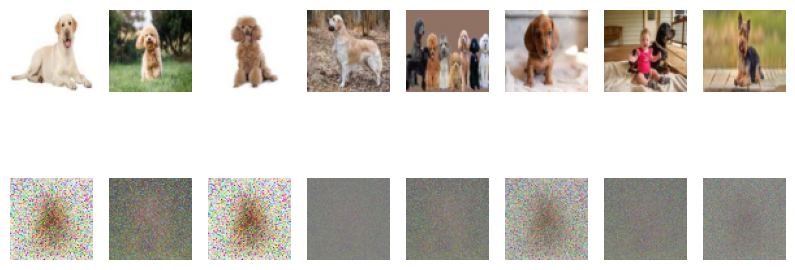

In [20]:
# defining the function to train the Autoencoder model
def train_autoencoder(model, dataloader, epochs=10, lr=1e-5):
    # initializing the Adam optimizer with a very small learning rate (1e-5)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # using Mean Squared Error (MSE) loss for reconstruction
    criterion = nn.MSELoss()
    
    # moving the model to the device (GPU or CPU)
    model.to(device)

    # loop through the number of epochs
    for epoch in range(epochs):
        # loop through batches of images in the dataloader
        for images, _ in dataloader:
            images = images.to(device)  # moving the images to the device
            
            # getting the model output for the input images
            outputs = model(images)
            
            # calculating the loss (reconstruction error)
            loss = criterion(outputs, images)
            
            # clearing previous gradients
            optimizer.zero_grad()
            
            # performing backpropagation
            loss.backward()
            
            # updating model weights
            optimizer.step()
        
        # printing the loss for each epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")
    
    return model  # returning the trained model

# initializing the Autoencoder model with a latent dimension of 128
ae_model = Autoencoder(latent_dim=128)

# training the Autoencoder model for 5 epochs using the provided dataloader
ae_model = train_autoencoder(ae_model, dataloader, epochs=5)

# visualizing the reconstruction of images from the trained Autoencoder model
visualize_reconstruction(ae_model, dataloader)

we can see that changing the epochs and learning rate together has brought in changes. but the image still is extremely poor.

# Conclusion

In this experiment, we investigated the performance of an Autoencoder (AE) and a Variational Autoencoder (VAE) for image reconstruction tasks, using a small dataset. Several factors, including the number of epochs and the learning rate, were explored to improve the reconstruction quality.

1. **Increasing Epochs:** As we increased the number of epochs, we observed a steady improvement in the reconstructed images. However, the improvement plateaued at a certain point, demonstrating that simply increasing epochs isn't a panacea. This is especially true for smaller datasets, where overfitting can occur, leading to diminishing returns after a point.
   
2. **Learning Rate Tuning:** When experimenting with different learning rates, we found that reducing the learning rate (step size) too much led to poor reconstruction quality, while increasing it too much caused poor overall image quality and incomplete reconstructions. The optimal learning rate is crucial for balancing fast convergence with the stability of the model. 

3. **Balance between Accuracy and Computational Expense:** As noted, with smaller datasets, the model may not fully learn the features, leading to subpar reconstructions. In real-world scenarios, especially with more complex datasets, we would need to strike a balance between training accuracy and computational costs. Increasing epochs for large datasets would also require more resources, and it’s important to avoid unnecessary overfitting.

4. **Autoencoder vs. Variational Autoencoder (VAE):** The AE generally showed better performance compared to the VAE, which is not surprising, as the VAE introduces additional complexity with the variational loss component, potentially making it more sensitive to small dataset sizes.

While we saw incremental improvements with changes in epochs and learning rates, further tuning and the use of a larger, more complex dataset would be necessary to achieve better results.

### Applications and Use Cases:

1. **Data Compression:** Autoencoders can be used for dimensionality reduction and data compression. In fields where storage space or bandwidth is limited, such as image or video streaming, autoencoders can efficiently compress data while retaining crucial information.

2. **Anomaly Detection:** Autoencoders are often used for detecting anomalies or outliers in data, such as fraudulent activity in banking, intrusion detection in cybersecurity, or identifying defects in manufacturing.

3. **Image Denoising:** In situations where images are corrupted by noise, autoencoders can be used to remove the noise and recover clean versions of the images, making them valuable for medical imaging or satellite image processing.

4. **Image Generation (for VAE):** Variational Autoencoders (VAE) are particularly useful in generative tasks, such as creating new images or other data types that are similar to a training dataset, with applications in art creation, style transfer, or even generating realistic synthetic medical images for research purposes.

5. **Feature Learning:** Autoencoders can also be used to learn compact representations of data, which can then be used in downstream tasks like classification or clustering. This is especially useful in areas where labeled data is scarce, such as in unsupervised learning or semi-supervised learning applications.

6. **Recommendation Systems:** In recommendation systems, autoencoders can be employed to find hidden patterns in user-item interaction data, which helps in making more personalized recommendations.

While the current results indicate that further adjustments are necessary to fully optimize performance, these methods can still play a significant role in the development of more efficient machine learning models for a variety of domains.